In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql import functions as F  
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
from pyspark.sql import DataFrame 
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
# read file
df_venmo = spark.read.parquet('VenmoSample.snappy.parquet')

In [ ]:
df_venmo.printSchema()
df_venmo.createOrReplaceTempView("df_venmo")

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)



In [ ]:
# The first time a user made the transaction
df_venmo_first_date = spark.sql("SELECT user1, MIN(datetime) AS First_Datetime \
                                 FROM (SELECT User1, datetime FROM df_venmo \
                                 UNION SELECT User2, datetime FROM df_venmo) t1 \
                                 GROUP BY user1")
df_venmo_first_date.createOrReplaceTempView('df_venmo_first_date')
df_venmo_first_date.show()


+-------+-------------------+
|  user1|     First_Datetime|
+-------+-------------------+
| 157793|2012-11-08 07:59:22|
| 255040|2013-11-12 05:56:32|
| 376270|2014-01-10 11:38:16|
| 377372|2014-03-10 00:26:05|
| 392476|2015-05-31 08:24:20|
| 400129|2014-04-20 03:51:40|
| 456851|2013-12-29 12:09:09|
| 470185|2013-10-03 09:23:14|
| 481749|2014-02-25 15:07:01|
| 485287|2014-09-26 20:14:43|
| 491584|2013-11-26 17:18:08|
| 504967|2015-04-19 06:33:56|
| 512750|2014-04-24 22:25:25|
| 638120|2013-11-18 09:56:21|
| 695980|2014-04-19 13:14:20|
| 857783|2014-02-28 04:34:46|
| 897873|2015-08-21 23:03:20|
| 952471|2014-05-15 12:05:40|
|1029768|2014-07-16 06:57:34|
|1030811|2015-07-05 22:42:53|
+-------+-------------------+
only showing top 20 rows



In [ ]:
# Create lifetime indicators
df_venmo_all = spark.sql('SELECT user1, user2, datetime FROM df_venmo\
                          UNION SELECT user2, user1, datetime FROM df_venmo')
df_venmo_all.createOrReplaceTempView('df_venmo_all')
#df_venmo_all.show()
df_venmo_lft = spark.sql ('SELECT t1.user1, t1.user2, t1.datetime, CEILING(DATEDIFF(t1.datetime,t2.First_Datetime)/30) AS lifetime_indicator FROM df_venmo_all t1 INNER JOIN df_venmo_first_date t2\
                          ON t1.user1 = t2.user1\
                          WHERE CEILING(DATEDIFF(t1.datetime,t2.First_Datetime)/30) >= 0 AND CEILING(DATEDIFF(t1.datetime,t2.First_Datetime)/30)<=12\
                          ORDER BY 1,4     ')
df_venmo_lft.createOrReplaceTempView('df_venmo_lft')
df_venmo_lft.show()

+-----+-------+-------------------+
|user1|  user2|           datetime|
+-----+-------+-------------------+
| 4262|   5234|2015-12-15 03:39:14|
|23372|  21669|2013-06-13 20:24:02|
|25330|  56799|2013-02-13 01:45:21|
|29489|  31249|2013-06-17 08:18:15|
|30655|  49860|2013-12-15 01:20:23|
|36275|  37166|2014-01-22 12:39:50|
|44189|  47257|2016-02-19 09:15:15|
|45827|  39716|2013-05-15 04:21:55|
|48173|  41673|2015-10-10 02:10:58|
|49753| 147331|2016-01-10 12:47:22|
|50024| 141099|2013-12-05 13:46:07|
|51320| 360702|2013-08-11 14:05:02|
|52122| 262551|2016-03-16 06:26:45|
|52565|3048817|2016-03-04 07:28:44|
|57751| 803442|2016-07-17 06:04:52|
|63883| 464526|2015-11-25 07:30:30|
|64130|  48651|2013-05-02 00:53:55|
|64891| 194967|2016-02-27 05:22:07|
|65457| 135284|2016-09-24 07:06:17|
|65573|  49044|2015-09-09 02:02:42|
+-----+-------+-------------------+
only showing top 20 rows

+-----+-------+-------------------+------------------+
|user1|  user2|           datetime|lifetime_indicator|


In [ ]:
# number of friends, and number of FFs across lifetime
friends_lft = spark.sql("SELECT user1 AS User, COUNT(DISTINCT user2) AS Num_Friend, lifetime_indicator \
                  FROM df_venmo_lft\
                  GROUP BY 1,3\
                  ORDER BY 1, 3")
friends_lft.createOrReplaceTempView('friends_lft')
#friends_lft.show()

# create continuous user lifetime
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = friends_lft.select("User").withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_usertime = df_usertime.withColumn("time_lst", F.explode(col("time_lst")))
df_usertime.createOrReplaceTempView("df_usertime")
df_usertime.show()

#friends_lft_continuous = spark.sql('SELECT User, lifetime_indicator, SUM(Num_Friend) AS Friend_Cnt\
#                                   FROM\
#                                  (SELECT User, Num_Friend, lifetime_indicator FROM friends_lft\
#                                   UNION \
#                                    SELECT User, 0, time_lst FROM df_usertime) T\
#                                    GROUP BY 1,2\
#                                    ORDER BY 1,2')
#friends_lft_continuous.createOrReplaceTempView('friends_lft_continuous')
#friends_lft_continuous.show()

In [ ]:
# number of FFs
FF_lft = spark.sql("SELECT t1.user1, COUNT(DISTINCT t2.user2) AS Num_FF, t1.lifetime_indicator\
                    FROM df_venmo_lft t1, df_venmo_lft t2\
                    WHERE t1.user2 = t2.user1 AND t1.datetime > t2.datetime AND t1.user1 <> t2.user2\
                    GROUP BY 1,3\
                    ORDER BY 1,3")
FF_lft.createOrReplaceTempView('FF_lft')

FF_lft_continuous = spark.sql('SELECT user1 AS User, lifetime_indicator, SUM(Num_FF) AS FF_Cnt\
                                    FROM\
                                    (SELECT user1, Num_FF, lifetime_indicator FROM FF_lft\
                                    UNION \
                                    SELECT User, 0, time_lst FROM df_usertime) T\
                                    GROUP BY 1,2\
                                    ORDER BY 1,2')
FF_lft_continuous.createOrReplaceTempView('FF_lft_continuous')
FF_lft_continuous.show()


+----+------------------+------+
|User|lifetime_indicator|FF_Cnt|
+----+------------------+------+
|   2|                 0|     0|
|   2|                 1|     0|
|   2|                 2|     0|
|   2|                 3|     0|
|   2|                 4|     0|
|   2|                 5|     0|
|   2|                 6|     0|
|   2|                 7|     0|
|   2|                 8|     0|
|   2|                 9|     0|
|   2|                10|     0|
|   2|                11|     0|
|   2|                12|     0|
|   3|                 0|     6|
|   3|                 1|     7|
|   3|                 2|     0|
|   3|                 3|     1|
|   3|                 4|     6|
|   3|                 5|     8|
|   3|                 6|     0|
+----+------------------+------+
only showing top 20 rows



# **Predictive Analytics**

**Task_7: Create dependent variable Y, i.e. the total number of transactions at lifetime
point 12. In other words, for every user, we need to count how many transactions s/he had
committed during her/his twelve months in Venmo.**

In [ ]:
df_venmo_y = spark.sql("SELECT user1, COUNT(*) AS y\
                        FROM df_venmo_lft\
                        GROUP BY user1\
                        ORDER BY 1")
df_venmo_y.createOrReplaceTempView('df_venmo_y')
df_venmo_y.show()

+-----+---+
|user1|  y|
+-----+---+
|    2|  1|
|    3|  9|
|    4|  4|
|    6|  2|
|    8|  6|
|    9|  5|
|   10| 12|
|   11| 13|
|   12|  5|
|   13|  5|
|   16|  7|
|   18|  1|
|   19|  2|
|   24|  2|
|   28|  2|
|   29|  2|
|   31|  1|
|   32|  1|
|   34|  5|
|   42|  5|
+-----+---+
only showing top 20 rows



**Task_8: Create the recency and frequency variables. In CRM (Customer Relationship Management), this predictive framework is
known as RFM. Here, we don’t have monetary amounts, so we will focus on just RF. Recency
refers to the last time a user was active, and frequency is how often a user uses Venmo in a
month. We need to compute these metrics across a user’s lifetime in Venmo (from 0 up to 12).**

In [ ]:
temp1 = spark.sql('SELECT t1.user1 AS user, t1.lifetime_indicator, MAX(DATEDIFF(t1.datetime,t2.First_Datetime)) AS max_days, COUNT(*) AS transactions\
                FROM df_venmo_lft t1\
                INNER JOIN df_venmo_first_date t2\
                ON t1.user1 = t2.user1\
                GROUP BY 1,2\
                ORDER BY 1,2')
temp1.createOrReplaceTempView('temp1')

temp2 = spark.sql('SELECT user, lifetime_indicator, MAX(max_days) AS days_max, SUM(transactions) AS transaction_cnt FROM \
                    (SELECT user, lifetime_indicator, max_days, transactions FROM temp1\
                    UNION \
                    SELECT User, time_lst,0,0 FROM df_usertime) t\
                    GROUP BY 1,2\
                    ORDER BY 1,2')
temp2.createOrReplaceTempView('temp2')
temp2.show()



+----+------------------+--------+---------------+
|user|lifetime_indicator|days_max|transaction_cnt|
+----+------------------+--------+---------------+
|   2|                 0|       0|              1|
|   2|                 1|       0|              0|
|   2|                 2|       0|              0|
|   2|                 3|       0|              0|
|   2|                 4|       0|              0|
|   2|                 5|       0|              0|
|   2|                 6|       0|              0|
|   2|                 7|       0|              0|
|   2|                 8|       0|              0|
|   2|                 9|       0|              0|
|   2|                10|       0|              0|
|   2|                11|       0|              0|
|   2|                12|       0|              0|
|   3|                 0|       0|              1|
|   3|                 1|      25|              1|
|   3|                 2|       0|              0|
|   3|                 3|      

In [ ]:
temp3 = spark.sql('SELECT user, lifetime_indicator, lifetime_indicator*30-days_max AS recency, transaction_cnt,\
                  SUM(transaction_cnt) OVER (PARTITION BY user ORDER BY lifetime_indicator) AS transaction_cnt_cum\
                  FROM temp2\
                  ORDER BY 1,2')
temp3.createOrReplaceTempView('temp3')
df_RF = spark.sql('SELECT user, lifetime_indicator,  recency, 30/transaction_cnt as frequency, (lifetime_indicator*30)/transaction_cnt_cum AS frequency_cum\
                  FROM temp3\
                 ORDER BY 1,2')
df_RF.createOrReplaceTempView('df_RF')
df_RF.show()

+----+------------------+-------+---------+------------------+
|user|lifetime_indicator|recency|frequency|     frequency_cum|
+----+------------------+-------+---------+------------------+
|   2|                 0|      0|     30.0|               0.0|
|   2|                 1|     30|     null|              30.0|
|   2|                 2|     60|     null|              60.0|
|   2|                 3|     90|     null|              90.0|
|   2|                 4|    120|     null|             120.0|
|   2|                 5|    150|     null|             150.0|
|   2|                 6|    180|     null|             180.0|
|   2|                 7|    210|     null|             210.0|
|   2|                 8|    240|     null|             240.0|
|   2|                 9|    270|     null|             270.0|
|   2|                10|    300|     null|             300.0|
|   2|                11|    330|     null|             330.0|
|   2|                12|    360|     null|            

In [ ]:
# create dataframe with two columns: user1 and time_list (0-12)
# each user has lifetime 0 to 12
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_timelst = df_venmo_y.withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_timelst = df_timelst.withColumn("time_lst", F.explode(col("time_lst")))

df_timelst.createOrReplaceTempView("df_timelst")
df_timelst.show()

+-----+---+--------+
|user1|  y|time_lst|
+-----+---+--------+
|    2|  1|       0|
|    2|  1|       1|
|    2|  1|       2|
|    2|  1|       3|
|    2|  1|       4|
|    2|  1|       5|
|    2|  1|       6|
|    2|  1|       7|
|    2|  1|       8|
|    2|  1|       9|
|    2|  1|      10|
|    2|  1|      11|
|    2|  1|      12|
|    3|  9|       0|
|    3|  9|       1|
|    3|  9|       2|
|    3|  9|       3|
|    3|  9|       4|
|    3|  9|       5|
|    3|  9|       6|
+-----+---+--------+
only showing top 20 rows



**Task_9: For each user’s lifetime point, regress recency and frequency on Y. Plot the MSE (Mean Squared Error)
for each lifetime point. In other words, the x-axis will be lifetime in months (0-12), and the
y-axis will be the MSE.**

In [ ]:
# combine x and y to an input df
df_input = spark.sql("select t1.user, t1.lifetime_indicator, t1.recency, t1.frequency, t1.frequency_cum, t2.y from df_RF t1\
                   join df_venmo_y t2  ON t1.user = t2.user1 \
                  order by 1,2")
df_input.createOrReplaceTempView("df_input")
df_input.show()

+----+------------------+-------+---------+------------------+---+
|user|lifetime_indicator|recency|frequency|     frequency_cum|  y|
+----+------------------+-------+---------+------------------+---+
|   2|                 0|      0|     30.0|               0.0|  1|
|   2|                 1|     30|     null|              30.0|  1|
|   2|                 2|     60|     null|              60.0|  1|
|   2|                 3|     90|     null|              90.0|  1|
|   2|                 4|    120|     null|             120.0|  1|
|   2|                 5|    150|     null|             150.0|  1|
|   2|                 6|    180|     null|             180.0|  1|
|   2|                 7|    210|     null|             210.0|  1|
|   2|                 8|    240|     null|             240.0|  1|
|   2|                 9|    270|     null|             270.0|  1|
|   2|                10|    300|     null|             300.0|  1|
|   2|                11|    330|     null|             330.0|

In [ ]:
df_input_0 = spark.sql("select * from df_input where lifetime_indicator=0 ")
df_input_1 = spark.sql("select * from df_input where lifetime_indicator=1 ")
df_input_2 = spark.sql("select * from df_input where lifetime_indicator=2 ")
df_input_3 = spark.sql("select * from df_input where lifetime_indicator=3 ")
df_input_4 = spark.sql("select * from df_input where lifetime_indicator=4 ")
df_input_5 = spark.sql("select * from df_input where lifetime_indicator=5 ")
df_input_6 = spark.sql("select * from df_input where lifetime_indicator=6 ")
df_input_7 = spark.sql("select * from df_input where lifetime_indicator=7 ")
df_input_8 = spark.sql("select * from df_input where lifetime_indicator=8 ")
df_input_9 = spark.sql("select * from df_input where lifetime_indicator=9 ")
df_input_10 = spark.sql("select * from df_input where lifetime_indicator=10 ")
df_input_11 = spark.sql("select * from df_input where lifetime_indicator=11 ")
df_input_12 = spark.sql("select * from df_input where lifetime_indicator=12 ")


In [ ]:
def lifetimeMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'frequency_cum', 
                                             'recency'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.8, 0.2], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

MSE_0 = lifetimeMSE(df_input_0)
print(MSE_0)
MSE_1 = lifetimeMSE(df_input_1)
print(MSE_1)

11.166400439154678
9.301101536659143


In [ ]:
#MSE_0 = lifetimeMSE(df_input_0)
#print(MSE_0)
#MSE_1 = lifetimeMSE(df_input_1)
#print(MSE_1)
MSE_2 = lifetimeMSE(df_input_2)
print(MSE_2)
MSE_3 = lifetimeMSE(df_input_3)
print(MSE_3)
MSE_4 = lifetimeMSE(df_input_4)
print(MSE_4)
MSE_5 = lifetimeMSE(df_input_5)
print(MSE_5)
MSE_6 = lifetimeMSE(df_input_6)
print(MSE_6)
MSE_7 = lifetimeMSE(df_input_7)
print(MSE_7)
MSE_8 = lifetimeMSE(df_input_8)
print(MSE_8)
MSE_9 = lifetimeMSE(df_input_9)
print(MSE_9)
MSE_10 = lifetimeMSE(df_input_10)
print(MSE_10)
MSE_11 = lifetimeMSE(df_input_11)
print(MSE_11)
MSE_12 = lifetimeMSE(df_input_12)
print(MSE_12)


8.084446478438807
7.097901998558801
6.602358425788969
6.037588356110848
5.553455041800598
5.219120318013135
4.975107116214238
4.7943364210459425
4.710037459264501
4.713526618708615
4.774126310349024


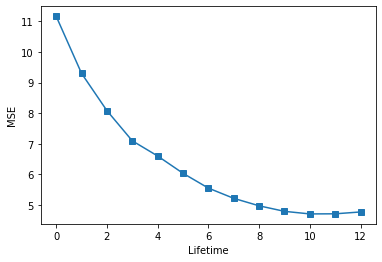

In [ ]:
MSE = []
MSE.extend([MSE_0,MSE_1,MSE_2,MSE_3,MSE_4,MSE_5,MSE_6,MSE_7,MSE_8,MSE_9,MSE_10,MSE_11,MSE_12])
lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot(lifetime, MSE, marker='s')
plt.xlabel('Lifetime')
plt.ylabel('MSE')
plt.show()

**Task_10: For each user’s lifetime point, regress recency, frequency AND her spending behavior
profile on Y. Plot the MSE for each lifetime point like above.**

In [ ]:
spending_profile_lft = spark.sql("SELECT user1, month, \
                                  CASE WHEN classification = 'Utility' THEN 1 \ 
                                  ELSE 0 \
                                  END AS utility,\
                                  CASE\
                                  WHEN classification = 'Food' THEN 1 \ 
                                  ELSE 0 \
                                  END AS food,\
                                  CASE\
                                  WHEN classification = 'Activity' THEN 1 \ 
                                  ELSE 0 \
                                  END AS activity,\
                                  CASE\
                                  WHEN classification = 'People' THEN 1 \ 
                                  ELSE 0 \
                                  END AS people ,\
                                  CASE\
                                  WHEN classification = 'Travel' THEN 1 \ 
                                  ELSE 0 \
                                  END AS travel,\
                                  CASE\
                                  WHEN classification = 'Illegal/Sarcasm' THEN 1 \ 
                                  ELSE 0 \
                                  END AS illegal,\
                                  CASE\
                                  WHEN classification = 'Unknown Category' THEN 1 \ 
                                  ELSE 0 \
                                  END AS other\
                                  FROM spending_behavior\
                                  ORDER BY 1,2")
spending_profile_lft.createOrReplaceTempView('spending_profile_lft')
temp = spark.sql("SELECT user1, month, utility, food, activity, people, travel, illegal, other\
                  UNION select User, time_lst, 0, 0, 0, 0, 0,0,0")
temp.createOrReplaceTempView('temp')
spending_profile_full = spark.sql("SELECT user1, month, SUM(utility) AS utility, SUM(food) AS food, SUM(activity) AS activity,\
                                   SUM(people) AS people, SUM(travel) AS travel, SUM(illegal) AS illegal, SUM(other) AS other\
                                   GROUP BY 1,2\
                                   ORDER BY 1,2")

In [ ]:
spending_rf = spark.sql("SELECT t1.user1, t1.month, t1.utility, t1.food, t1.people, t1.travel, t1.activity, t1.illegal, t1.other, \
                          t2.frequency_cum, t2.recency, t2.y\
                          FROM spending_profile_full t1\
                          JOIN df_input t2 ON t1.user1 = t2.user AND t1.month = t2.lifetime_indicator\
                          ORDER BY 1,2")
spending_rf.createOrReplaceTempView('spending_rf')

In [ ]:
df_input_rf_spd_0 = spark.sql("select * from spending_rf where month=0 ")
df_input_rf_spd_1 = spark.sql("select * from spending_rf where month=1 ")
df_input_rf_spd_2 = spark.sql("select * from spending_rf where month=2 ")
df_input_rf_spd_3 = spark.sql("select * from spending_rf where month=3 ")
df_input_rf_spd_4 = spark.sql("select * from spending_rf where month=4 ")
df_input_rf_spd_5 = spark.sql("select * from spending_rf where month=5 ")
df_input_rf_spd_6 = spark.sql("select * from spending_rf where month=6 ")
df_input_rf_spd_7 = spark.sql("select * from spending_rf where month=7 ")
df_input_rf_spd_8 = spark.sql("select * from spending_rf where month=8 ")
df_input_rf_spd_9 = spark.sql("select * from spending_rf where month=9 ")
df_input_rf_spd_10 = spark.sql("select * from spending_rf where month=10 ")
df_input_rf_spd_11 = spark.sql("select * from spending_rf where month=11 ")
df_input_rf_spd_12 = spark.sql("select * from spending_rf where month=12 ")


In [ ]:
def spendingRFMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['month', 'recency', 
                                'frequency_cum', 'utility', "food",'people','travel','activity','illegal','other'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.8, 0.2], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [ ]:
MSE_rf_spd_0 = spendingRFMSE(df_input_rf_spd_0)
MSE_rf_spd_1 = spendingRFMSE(df_input_rf_spd_1)
MSE_rf_spd_2 = spendingRFMSE(df_input_rf_spd_2)
MSE_rf_spd_3 = spendingRFMSE(df_input_rf_spd_3)
MSE_rf_spd_4 = spendingRFMSE(df_input_rf_spd_4)
MSE_rf_spd_5 = spendingRFMSE(df_input_rf_spd_5)
MSE_rf_spd_6 = spendingRFMSE(df_input_rf_spd_6)
MSE_rf_spd_7 = spendingRFMSE(df_input_rf_spd_7)
MSE_rf_spd_8 = spendingRFMSE(df_input_rf_spd_8)
MSE_rf_spd_9 = spendingRFMSE(df_input_rf_spd_9)
MSE_rf_spd_10 = spendingRFMSE(df_input_rf_spd_10)
MSE_rf_spd_11 = spendingRFMSE(df_input_rf_spd_11)
MSE_rf_spd_12 = spendingRFMSE(df_input_rf_spd_12)

In [ ]:
MSE_rf_spd = []
MSE_rf_spd.extend([MSE_rf_spd_0,MSE_rf_spd_1,MSE_rf_spd_2,MSE_rf_spd_3,MSE_rf_spd_4,MSE_rf_spd_5,MSE_rf_spd_6,MSE_rf_spd_7,MSE_rf_spd_8,MSE_rf_spd_9,MSE_rf_spd_10,MSE_rf_spd_11,MSE_rf_spd_12])
lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot(lifetime, MSE_rf_spd, marker='s')
plt.xlabel('Lifetime')
plt.ylabel('MSE')
plt.show()

**Task_11: For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for
each lifetime point like above.**

In [ ]:
df_input_sn = spark.sql('SELECT t1.user, t1.lifetime_indicator, t1.friend_count , t1.cum_friend_count,t1.fof_count, t1.cum_fof_count, t1.cluster_coef,\
                          t2.pagerank, t3.y\
                          FROM social_network_all t1 JOIN df_pagerank t2 ON t1.user=t2.user\
                          JOIN df_venmo_y t3 ON t1.user = t3.user\
                          ORDER BY 1,2')
df_input_sn.show()
df_input_sn.createOrReplaceTempView('df_input_sn')

In [ ]:
df_input_sn_0 = spark.sql("select * from df_input_sn where lifetime_indicator=0 ")
df_input_sn_1 = spark.sql("select * from df_input_sn where lifetime_indicator=1 ")
df_input_sn_2 = spark.sql("select * from df_input_sn where lifetime_indicator=2 ")
df_input_sn_3 = spark.sql("select * from df_input_sn where lifetime_indicator=3 ")
df_input_sn_4 = spark.sql("select * from df_input_sn where lifetime_indicator=4 ")
df_input_sn_5 = spark.sql("select * from df_input_sn where lifetime_indicator=5 ")
df_input_sn_6 = spark.sql("select * from df_input_sn where lifetime_indicator=6 ")
df_input_sn_7 = spark.sql("select * from df_input_sn where lifetime_indicator=7 ")
df_input_sn_8 = spark.sql("select * from df_input_sn where lifetime_indicator=8 ")
df_input_sn_9 = spark.sql("select * from df_input_sn where lifetime_indicator=9 ")
df_input_sn_10 = spark.sql("select * from df_input_sn where lifetime_indicator=10 ")
df_input_sn_11 = spark.sql("select * from df_input_sn where lifetime_indicator=11 ")
df_input_sn_12 = spark.sql("select * from df_input_sn where lifetime_indicator=12 ")

In [ ]:
def socialnetworkMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friend_count', 
                                'fof_count', 'cluster_coef', "pagerank"], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.8, 0.2], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    coef = lrModel.coefficients
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [ ]:
MSE_sn_0 = socialnetworkMSE(df_input_sn_0)
MSE_sn_1 = socialnetworkMSE(df_input_sn_1)
MSE_sn_2 = socialnetworkMSE(df_input_sn_2)
MSE_sn_3 = socialnetworkMSE(df_input_sn_3)
MSE_sn_4 = socialnetworkMSE(df_input_sn_4)
MSE_sn_5 = socialnetworkMSE(df_input_sn_5)
MSE_sn_6 = socialnetworkMSE(df_input_sn_6)
MSE_sn_7 = socialnetworkMSE(df_input_sn_7)
MSE_sn_8 = socialnetworkMSE(df_input_sn_8)
MSE_sn_9 = socialnetworkMSE(df_input_sn_9)
MSE_sn_10 = socialnetworkMSE(df_input_sn_10)
MSE_sn_11 = socialnetworkMSE(df_input_sn_11)
MSE_sn_12 = socialnetworkMSE(df_input_sn_12)

In [ ]:
MSE_sn = []
MSE_sn.extend([MSE_sn_0,MSE_sn_1,MSE_sn_2,MSE_sn_3,MSE_sn_4,MSE_sn_5,MSE_sn_6,MSE_sn_7,MSE_sn_8,MSE_sn_9,MSE_sn_10,MSE_sn_11,MSE_sn_12])
lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot(lifetime, MSE_sn, marker='s')
plt.xlabel('Lifetime')
plt.ylabel('MSE')
plt.show()

**Task_12: For each user’s lifetime point, regress her social network metrics and the spending
behaviour of her social network on Y. Plot the MSE for each lifetime point like above.**

In [ ]:
# Join SN matrics and spending behavior 
input_sn_spd = spark.sql('SELECT t1.user, t1.lifetime_indicator, t1.friend_count, t1.fof_count, t1.cluster_coef, t1.pagerank, t1.y,\
                          t2.travel, t2.people, t2.food, t2.activity, t2.utility, t2.illegal, t2.other\
                          FROM df_input_sn t1, spending_profile_full t2 ON t1.user = t2.user1 AND t2.lifetime_indicator = t2.month\
                          ORDER BY 1,2')
input_sn_spd.createOrReplaceTempView('input_sn_spd')

In [ ]:
df_input_sn_spd_0 = spark.sql("select * from input_sn_spd where lifetime_indicator=0 ")
df_input_sn_spd_1 = spark.sql("select * from input_sn_spd where lifetime_indicator=1 ")
df_input_sn_spd_2 = spark.sql("select * from input_sn_spd where lifetime_indicator=2 ")
df_input_sn_spd_3 = spark.sql("select * from input_sn_spd where lifetime_indicator=3 ")
df_input_sn_spd_4 = spark.sql("select * from input_sn_spd where lifetime_indicator=4 ")
df_input_sn_spd_5 = spark.sql("select * from input_sn_spd where lifetime_indicator=5 ")
df_input_sn_spd_6 = spark.sql("select * from input_sn_spd where lifetime_indicator=6 ")
df_input_sn_spd_7 = spark.sql("select * from input_sn_spd where lifetime_indicator=7 ")
df_input_sn_spd_8 = spark.sql("select * from input_sn_spd where lifetime_indicator=8 ")
df_input_sn_spd_9 = spark.sql("select * from input_sn_spd where lifetime_indicator=9 ")
df_input_sn_spd_10 = spark.sql("select * from input_sn_spd where lifetime_indicator=10 ")
df_input_sn_spd_11 = spark.sql("select * from input_sn_spd where lifetime_indicator=11 ")
df_input_sn_spd_12 = spark.sql("select * from input_sn_spd where lifetime_indicator=12 ")





In [ ]:
def SNspendingMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friend_count', 
                                'fof_count', 'cluster_coef', "pagerank",'activity','utility','people','illegal','other','travel','food'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.8, 0.2], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    coef = lrModel.coefficients
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [ ]:
MSE_sn_spd_0 = socialnetworkMSE(df_input_sn_spd_0)
MSE_sn_spd_1 = socialnetworkMSE(df_input_sn_spd_1)
MSE_sn_spd_2 = socialnetworkMSE(df_input_sn_spd_2)
MSE_sn_spd_3 = socialnetworkMSE(df_input_sn_spd_3)
MSE_sn_spd_4 = socialnetworkMSE(df_input_sn_spd_4)
MSE_sn_spd_5 = socialnetworkMSE(df_input_sn_spd_5)
MSE_sn_spd_6 = socialnetworkMSE(df_input_sn_spd_6)
MSE_sn_spd_7 = socialnetworkMSE(df_input_sn_spd_7)
MSE_sn_spd_8 = socialnetworkMSE(df_input_sn_spd_8)
MSE_sn_spd_9 = socialnetworkMSE(df_input_sn_spd_9)
MSE_sn_spd_10 = socialnetworkMSE(df_input_sn_spd_10)
MSE_sn_spd_11 = socialnetworkMSE(df_input_sn_spd_11)
MSE_sn_spd_12 = socialnetworkMSE(df_input_sn_spd_12)

In [ ]:
MSE_sn_spd = []
MSE_sn_spd.extend([MSE_sn_spd_0,MSE_sn_spd_1,MSE_sn_spd_2,MSE_sn_spd_3,MSE_sn_spd_4,MSE_sn_spd_5,MSE_sn_spd_6,MSE_sn_spd_7,MSE_sn_spd_8,MSE_sn_spd_9,MSE_sn_spd_10,MSE_sn_spd_11,MSE_sn_spd_12])
lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot(lifetime, MSE_sn_spd, marker='s')
plt.xlabel('Lifetime')
plt.ylabel('MSE')
plt.show()